<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07C%20-%20Text%20Classification%20Deep%20Learning%20Sequential%20Models%20LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Deep Learning Sequential Models - LSTMs


Another new and interesting approach to supervised deep learning is the use
of recurrent neural networks (RNNs) and long short-term memory networks (LSTMs)
which also considers the sequence of data (words, events and so on). These are more
advanced models than your regular fully connected deep networks and usually take
more time to train.


In [1]:
!nvidia-smi

Mon Aug  5 22:45:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [4]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [5]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [0]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [8]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:07<00:00, 2078.76it/s]

CPU times: user 24.1 s, sys: 120 ms, total: 24.2 s
Wall time: 24.2 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [0]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [10]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175859), ('<PAD>', 0), 1)

In [0]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [12]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175860
Number of Documents=35000


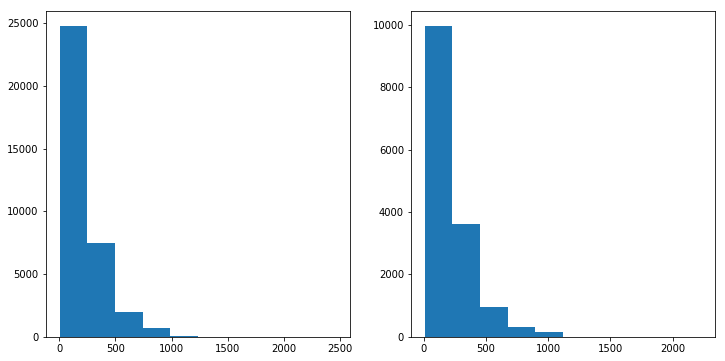

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [0]:
MAX_SEQUENCE_LENGTH = 1000

In [15]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [0]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [0]:
VOCAB_SIZE = len(t.word_index)

# LSTM Model

# Build Model Architecture


# Embeddings

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words. 

![](https://i.imgur.com/WuV47DW.png)


# LSTM

LSTMs try to overcome
the shortcomings of RNN models, especially with regard to handling long-term
dependencies and problems that occur when the weight matrix associated with the
units (neurons) become too small (leading to vanishing gradient) or too large (leading to
exploding gradient). These architectures are more complex than regular deep networks
and going into detailed internals and math concepts are out of the current scope, but we
will try to cover the essentials here without making it math heavy

![](https://i.imgur.com/c8qGKX8.png)

The sequence of operations in the LSTM cell is briefly shown as follows.

![](https://i.imgur.com/uiIbDk1.png)

In [19]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

W0805 22:46:38.471840 140398715598720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 22:46:38.522899 140398715598720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 22:46:38.686693 140398715598720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         52758000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 300)         0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 128)               220160    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 53,011,441
Trainable params: 53,011,441
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [20]:
batch_size = 100
model.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/2
31500/31500 [==============================] - 41s 1ms/sample - loss: 0.4056 - acc: 0.8143 - val_loss: 0.3039 - val_acc: 0.8820
Epoch 2/2
31500/31500 [==============================] - 39s 1ms/sample - loss: 0.1714 - acc: 0.9373 - val_loss: 0.3678 - val_acc: 0.8746


## Evaluate Model Performance

In [21]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

15000/15000 [==============================] - 9s 615us/sample - loss: 0.3638 - acc: 0.8816
Accuracy: 88.16%


In [22]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [23]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      7490
    positive       0.90      0.85      0.88      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,negative,positive
negative,6805,685
positive,1091,6419


# Stacked LSTM Model

## Build Model Architecture

In [25]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         52758000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1000, 128)         220160    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 53,143,537
Trainable params: 53,143,537
Non-trainable params: 0
__________________________________________

## Train Model

In [26]:
batch_size = 100
model2.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
           shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/2
31500/31500 [==============================] - 62s 2ms/sample - loss: 0.4060 - acc: 0.8144 - val_loss: 0.3236 - val_acc: 0.8709
Epoch 2/2
31500/31500 [==============================] - 61s 2ms/sample - loss: 0.1717 - acc: 0.9379 - val_loss: 0.3316 - val_acc: 0.8723


## Evaluate Model Performance

In [27]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

15000/15000 [==============================] - 18s 1ms/sample - loss: 0.3281 - acc: 0.8712
Accuracy: 87.12%


In [28]:
predictions = model2.predict_classes(X_test).ravel()
predictions[:10]

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [29]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive']

In [30]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.90      0.83      0.87      7490
    positive       0.84      0.91      0.88      7510

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



,negative,positive
negative,6222,1268
positive,664,6846
